# Dataset

In [69]:
import os
import cv2
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd

gray_dir = '/home/przemek/studia/sp2/pedestrian/input/'
gt_dir = '/home/przemek/studia/sp2/pedestrian/groundtruth/'
frame_dir = '/home/przemek/studia/sp2/pedestrian/input/'

frame_files = natsorted([f for f in os.listdir(gray_dir) if f.endswith('.jpg')])
frame_files = frame_files[540:]  

gray_images_array = []
colour_images_array = []
gt_array = []

for i in range(179):  
    gray = cv2.imread(os.path.join(gray_dir, frame_files[i]), cv2.IMREAD_GRAYSCALE)
    colour = cv2.imread(os.path.join(gray_dir, frame_files[i]), cv2.IMREAD_COLOR)
    gt = cv2.imread(os.path.join(gt_dir, frame_files[i].replace('in', 'gt').replace('.jpg', '.png')), cv2.IMREAD_GRAYSCALE)
    
    gray_images_array.append(gray)
    colour_images_array.append(colour)

    ys, xs = np.where(gt == 255)
    if len(xs) > 0 and len(ys) > 0:
        x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)
        gt_array.append([x1, y1, x2, y2])


frame_dir = '/home/przemek/studia/sp2/pedestrian/input/'

# Quadtree Decomposition and ground truth computing

### 3.2.1, 3.2.2

In [70]:
def compute_grth(image):
    flat = image.flatten()
    q1 = np.percentile(flat, 25)
    q3 = np.percentile(flat, 75)
    return (q3 - q1) / 2

def quad_tree_granulation(image, threshold=None, min_size=4):
    h, w = image.shape
    granules = []

    if threshold is None:
        threshold = compute_grth(image)

    def divide(x, y, w_, h_):
        if w_ <= 0 or h_ <= 0:
            return
        patch = image[y:y+h_, x:x+w_]
        if patch.size == 0:
            return
        min_val = np.min(patch)
        max_val = np.max(patch)

        if (max_val - min_val > threshold) and (w_ > min_size and h_ > min_size):
            hw = w_ // 2
            hh = h_ // 2
            divide(x, y, hw, hh)
            divide(x + hw, y, w_ - hw, hh)
            divide(x, y + hh, hw, h_ - hh)
            divide(x + hw, y + hh, w_ - hw, h_ - hh)
        else:
            cx = x + w_ // 2
            cy = y + h_ // 2
            granules.append((x, y, w_, h_, cx, cy))  

    divide(0, 0, w, h)
    return granules


# Quadtree decomposition test

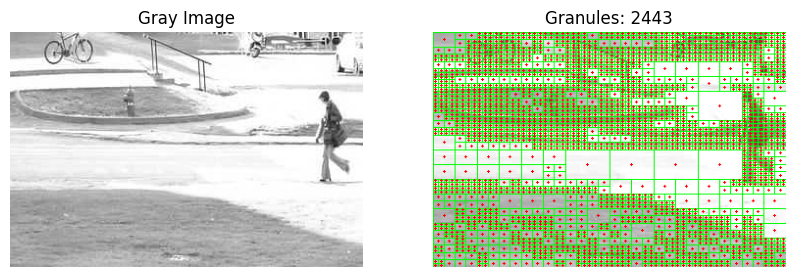

In [71]:
img_path = os.path.join(frame_dir, frame_files[0])
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

granules = quad_tree_granulation(image)

image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)


for x, y, w, h, cx, cy in granules:
    cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 255, 0), 1)   
    cv2.circle(image_color, (cx, cy), 1, (0, 0, 255), -1)               

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Gray Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title(f"Granules: {len(granules)}")
plt.axis("off")
plt.show()


# Rough entropy based threshold calculation

### 3.2.3

In [72]:
def compute_optimal_threshold(image, granules, prev_threshold=None, base=2):
    max_gray = int(np.max(image))
    min_gray = int(np.min(image))
    gray_range = max_gray - min_gray + 1

    object_lower = np.zeros(gray_range, dtype=np.float64)
    object_upper = np.zeros(gray_range, dtype=np.float64)
    background_lower = np.zeros(gray_range, dtype=np.float64)
    background_upper = np.zeros(gray_range, dtype=np.float64)

    if prev_threshold is not None:
        start_threshold = max(min_gray, prev_threshold - 10)
        end_threshold = min(max_gray, prev_threshold + 10)
    else:
        start_threshold = min_gray
        end_threshold = max_gray

    for (x, y, w, h, *_ ) in granules:
        patch = image[y:y+h, x:x+w]
        if patch.size == 0:
            continue
        min_g = int(np.min(patch))
        max_g = int(np.max(patch))
        size = w * h

        for j in range(max_g, end_threshold + 1):
            idx = j - min_gray
            object_lower[idx] += size

        for j in range(min_g, end_threshold + 1):
            idx = j - min_gray
            object_upper[idx] += size

        for j in range(start_threshold, min_g + 1):
            idx = j - min_gray
            background_lower[idx] += size

        for j in range(start_threshold, max_g + 1):
            idx = j - min_gray
            background_upper[idx] += size

    rough_entropy = np.full(gray_range, -np.inf, dtype=np.float64)

    for l in range(start_threshold, end_threshold + 1):
        idx = l - min_gray
        obj_l = object_lower[idx]
        obj_u = object_upper[idx]
        bg_l = background_lower[idx]
        bg_u = background_upper[idx]

        obj_rough = 1 - obj_l / obj_u if obj_u > 0 else 1
        bg_rough = 1 - bg_l / bg_u if bg_u > 0 else 1

        obj_entropy = 1.0 if obj_rough <= 1/base else obj_rough * np.log(obj_rough) / np.log(base)
        bg_entropy = 1.0 if bg_rough <= 1/base else bg_rough * np.log(bg_rough) / np.log(base)

        rough_entropy[idx] = - (base / 2) * (obj_entropy + bg_entropy)

    best_idx = np.argmax(rough_entropy[start_threshold - min_gray : end_threshold - min_gray + 1])
    T_star = start_threshold + best_idx

    return T_star, rough_entropy[start_threshold - min_gray : end_threshold - min_gray + 1]


# Rough entropy test

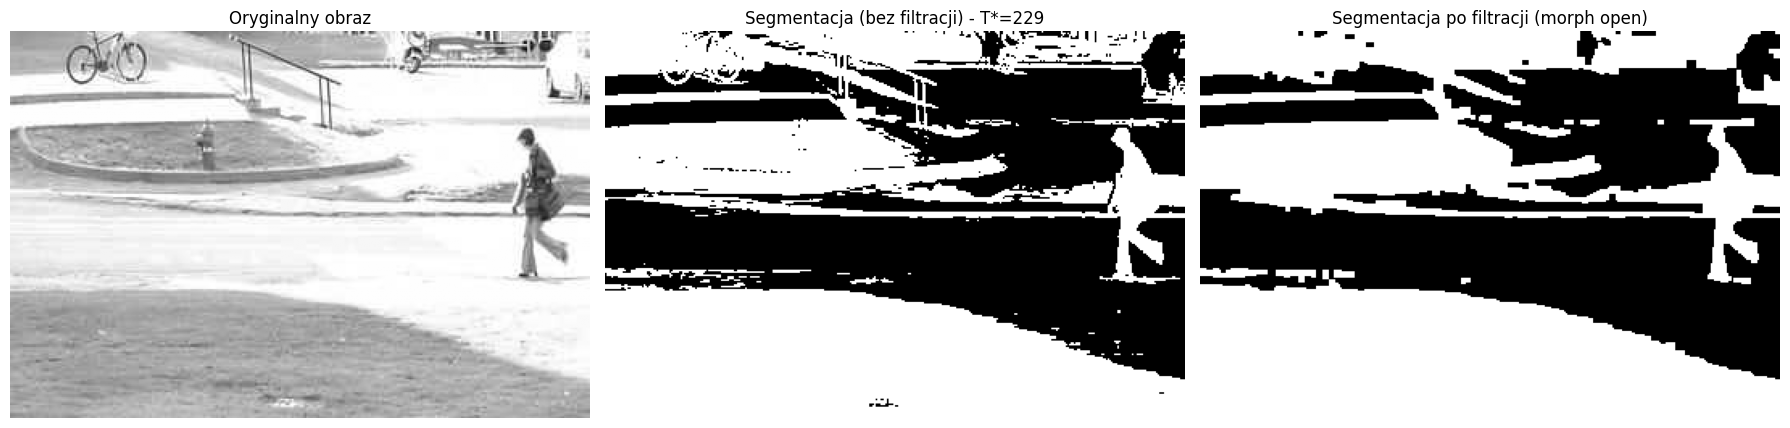

In [73]:
def visualize_segmentation(image, threshold):
    binary_mask = (image >= threshold).astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Oryginalny obraz")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(255 - binary_mask, cmap='gray')
    plt.title(f"Segmentacja (bez filtracji) - T*={threshold}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(255 - cleaned_mask, cmap='gray')
    plt.title("Segmentacja po filtracji (morph open)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


T_star, _ = compute_optimal_threshold(image, granules)
visualize_segmentation(image, T_star)


In [74]:
def evaluate_segmentation(pred_mask, gt_mask):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    return {
        'accuracy': np.mean(pred_flat == gt_flat),
        'precision': precision_score(gt_flat, pred_flat, zero_division=0),
        'recall': recall_score(gt_flat, pred_flat, zero_division=0),
        'f1': f1_score(gt_flat, pred_flat, zero_division=0),
        'iou': jaccard_score(gt_flat, pred_flat, zero_division=0),
    }

def load_ground_truth(gt_path):
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    return (gt == 255).astype(np.uint8)  

def evaluate_all_frames(frame_files, gt_dir, frame_dir):
    results = []
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    for fname in frame_files[:100]:  
        img_path = os.path.join(frame_dir, fname)
        gt_path = os.path.join(gt_dir, fname.replace('in', 'gt').replace('.jpg', '.png'))

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = load_ground_truth(gt_path)

        if np.sum(gt_mask) == 0:
            continue  

        granules = quad_tree_granulation(image)
        T_star, _ = compute_optimal_threshold(image, granules)

        binary_mask = (image >= T_star).astype(np.uint8) * 255
        opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        cleaned_mask = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
        pred_mask = (cleaned_mask > 0).astype(np.uint8)

        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask.flatten()

        results.append({
            'frame': fname,
            'accuracy': np.mean(pred_flat == gt_flat),
            'precision': precision_score(gt_flat, pred_flat, zero_division=0),
            'recall': recall_score(gt_flat, pred_flat, zero_division=0),
            'f1': f1_score(gt_flat, pred_flat, zero_division=0),
            'iou': jaccard_score(gt_flat, pred_flat, zero_division=0),
        })

    return pd.DataFrame(results)

df_results = evaluate_all_frames(frame_files, gt_dir, frame_dir)

print("📊 Średnie metryki (dla klatek z foregroundem):")
print(df_results[['accuracy', 'precision', 'recall', 'f1', 'iou']].mean())

df_results.to_csv('rough_entropy_results_pedestrian.csv', index=False)


📊 Średnie metryki (dla klatek z foregroundem):
accuracy     0.491331
precision    0.000187
recall       0.008086
f1           0.000364
iou          0.000182
dtype: float64


# Temporal Segmentation Through Background Estimation

### 3.3

In [75]:
def filter_small_objects(mask, min_area=100):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    filtered = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered[labels == i] = 255
    return filtered


def estimate_background_mask(f_t, f1, f2, f3, E=3):
    f1 = f1.astype(np.uint8)
    f2 = f2.astype(np.uint8)
    f3 = f3.astype(np.uint8)
    f_t = f_t.astype(np.uint8)

    a = np.maximum.reduce([f1, f2, f3])
    c = np.minimum.reduce([f1, f2, f3])
    b = np.median(np.stack([f1, f2, f3]), axis=0).astype(np.uint8)

    mu = (a + 4 * b + c) / 6
    sigma = (a - c) / 6
    sigma[sigma == 0] = 1 

    diff = np.abs(f_t.astype(np.float32) - mu.astype(np.float32))
    fg_mask = (diff > E * sigma).astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    return filter_small_objects(cleaned, min_area=80)


## Test

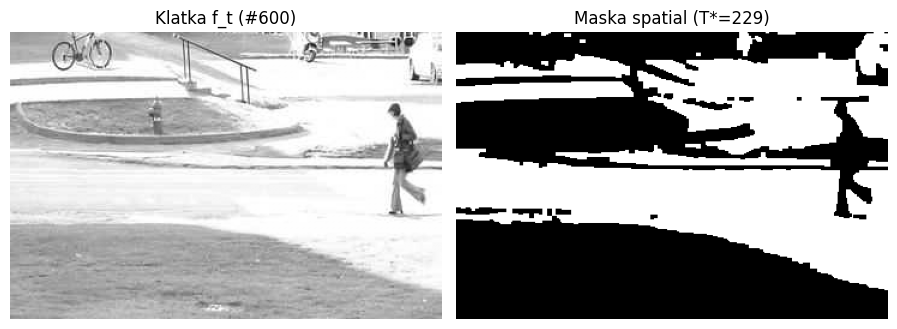

In [76]:
def load_gray_frame(index, frame_dir, frame_files):
    path = os.path.join(frame_dir, frame_files[index])
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

t = 0
E = 4
min_area = 30  

frame0 = load_gray_frame(t, frame_dir, frame_files)      
frame1 = load_gray_frame(t - 1, frame_dir, frame_files)
frame2 = load_gray_frame(t - 2, frame_dir, frame_files)
frame3 = load_gray_frame(t - 3, frame_dir, frame_files)

temporal_mask = estimate_background_mask(frame0, frame1, frame2, frame3, E=E)

granules = quad_tree_granulation(frame0)
T_star, _ = compute_optimal_threshold(frame0, granules)

binary_mask = (frame0 >= T_star).astype(np.uint8) * 255
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
spatial_mask = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

fused_mask = np.logical_and(spatial_mask > 0, temporal_mask > 0).astype(np.uint8) * 255

gt_file = frame_files[t].replace('in', 'gt').replace('.jpg', '.png')
gt_path = os.path.join(gt_dir, gt_file)
gt_mask = load_ground_truth(gt_path)

evaluate_segmentation((fused_mask > 0).astype(np.uint8), gt_mask)

plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(frame0, cmap='gray')
plt.title(f"Klatka f_t (#{t + 600})")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(spatial_mask, cmap='gray')
plt.title(f"Maska spatial (T*={T_star})")
plt.axis("off")

plt.tight_layout()
plt.show()


### test na wielu klatkach

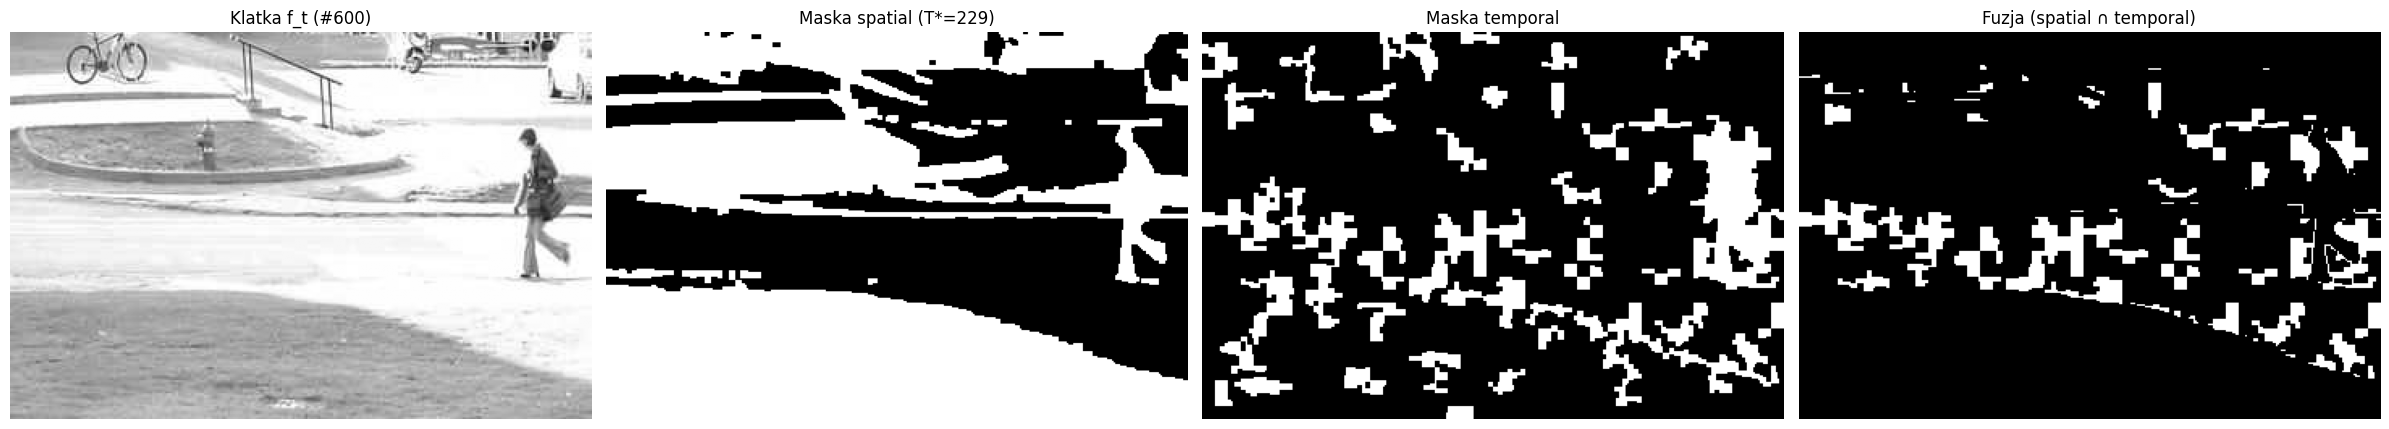

📊 Metryki dla klatki #600:
accuracy  : 0.8902
precision : 0.0000
recall    : 0.0000
f1        : 0.0000
iou       : 0.0000

📉 Średnie metryki (dla klatek z foregroundem):
accuracy     0.8941
precision    0.0444
recall       0.3855
f1           0.0785
iou          0.0413
dtype: float64


In [77]:
def load_gray(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def load_ground_truth(gt_path):
    gt = load_gray(gt_path)
    return (gt == 255).astype(np.uint8)

def evaluate(gt_mask, pred_mask):
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()
    return {
        'accuracy': np.mean(pred_flat == gt_flat),
        'precision': precision_score(gt_flat, pred_flat, zero_division=0),
        'recall': recall_score(gt_flat, pred_flat, zero_division=0),
        'f1': f1_score(gt_flat, pred_flat, zero_division=0),
        'iou': jaccard_score(gt_flat, pred_flat, zero_division=0)
    }

def filter_small_objects(mask, min_area=100):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    filtered = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered[labels == i] = 255
    return filtered

def estimate_background_mask(f_t, f1, f2, f3, E=3):
    a = np.maximum(np.maximum(f1, f2), f3)
    c = np.minimum(np.minimum(f1, f2), f3)
    b = np.median(np.stack([f1, f2, f3]), axis=0)
    mu = (a + 4 * b + c) / 6
    sigma = (a - c) / 6
    diff = np.abs(f_t.astype(np.float32) - mu.astype(np.float32))
    fg_mask = (diff > E * sigma).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opened = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return filter_small_objects(closed, min_area=120)

t = 0
f_paths = [os.path.join(frame_dir, frame_files[t - i]) for i in range(3, 0, -1)]
f_t_path = os.path.join(frame_dir, frame_files[t])
gt_path = os.path.join(gt_dir, frame_files[t].replace('in', 'gt').replace('.jpg', '.png'))

f1, f2, f3 = [load_gray(p) for p in f_paths]
f_t = load_gray(f_t_path)
gt_mask = load_ground_truth(gt_path)

temporal_mask = estimate_background_mask(f_t, f1, f2, f3, E=4)

granules = quad_tree_granulation(f_t)
T_star, _ = compute_optimal_threshold(f_t, granules)
binary_mask = (f_t >= T_star).astype(np.uint8) * 255
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
spatial_mask = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(24, 5))
plt.subplot(1, 4, 1)
plt.imshow(f_t, cmap='gray')
plt.title(f"Klatka f_t (#{t + 600})")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(255 - spatial_mask, cmap='gray')
plt.title(f"Maska spatial (T*={T_star})")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(temporal_mask, cmap='gray')
plt.title("Maska temporal")
plt.axis("off")

fused_mask = np.logical_and(spatial_mask > 0, temporal_mask > 0).astype(np.uint8) * 255

plt.subplot(1, 4, 4)
plt.imshow(fused_mask, cmap='gray')
plt.title("Fuzja (spatial ∩ temporal)")
plt.axis("off")


plt.tight_layout()
plt.show()

metrics = evaluate(gt_mask, (fused_mask > 0).astype(np.uint8))
print(f"📊 Metryki dla klatki #{t + 600}:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.4f}")

results = []
for i in range(3, len(frame_files)):
    paths = [os.path.join(frame_dir, frame_files[j]) for j in range(i - 3, i)]
    f_t_path = os.path.join(frame_dir, frame_files[i])
    gt_path = os.path.join(gt_dir, frame_files[i].replace('in', 'gt').replace('.jpg', '.png'))

    f1, f2, f3 = [load_gray(p) for p in paths]
    f_t = load_gray(f_t_path)
    gt_mask = load_ground_truth(gt_path)
    if np.sum(gt_mask) == 0:
        continue

    mask = estimate_background_mask(f_t, f1, f2, f3, E=3)
    pred_mask = (mask > 0).astype(np.uint8)
    metrics = evaluate(gt_mask, pred_mask)
    metrics['frame'] = frame_files[i]
    results.append(metrics)

df = pd.DataFrame(results)
print("\n📉 Średnie metryki (dla klatek z foregroundem):")
print(df[['accuracy', 'precision', 'recall', 'f1', 'iou']].mean().round(4))
df.to_csv('3point_temporal_results.csv', index=False)

# Algorithm for tracking 

### 3.4, Initialization, speed, dx, dy

In [78]:
def center(box):
    x1, y1, x2, y2 = box
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def init_tracking(groundtruth_array):
    prev_prev_tracker = groundtruth_array[0]
    prev_tracker = groundtruth_array[1]

    cx0, cy0 = center(prev_prev_tracker)
    cx1, cy1 = center(prev_tracker)

    dx = -(cx1 - cx0)
    dy = -(cy1 - cy0)
    s = np.sqrt((cx1 - cx0)**2 + (cy1 - cy0)**2)

    tracker = {
        'prev_threshold': None,
        'prev_tracker': prev_tracker,
        'prev_prev_tracker': prev_prev_tracker,
        'dx': dx,
        'dy': dy,
        's': s
    }
    return tracker

gt_array_1 = [
    [100, 100, 140, 140],  
    [110, 110, 150, 150]   
]

tracker = init_tracking(gt_array_1)

print("dx:", tracker['dx'])
print("dy:", tracker['dy'])
print("s:", tracker['s'])


dx: -10.0
dy: -10.0
s: 14.142135623730951


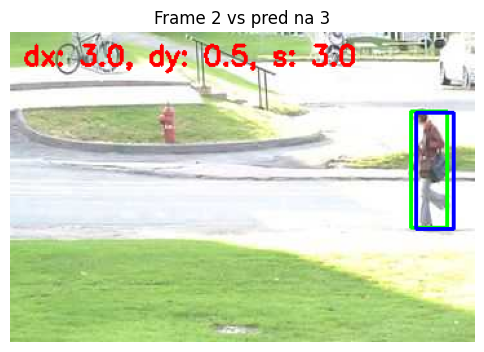

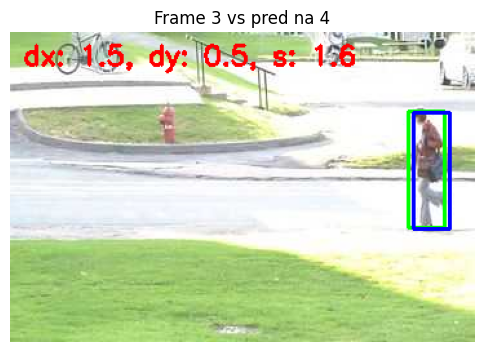

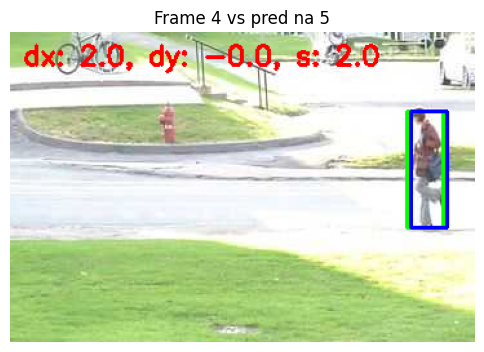

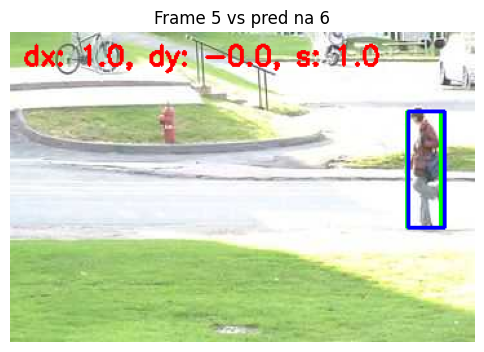

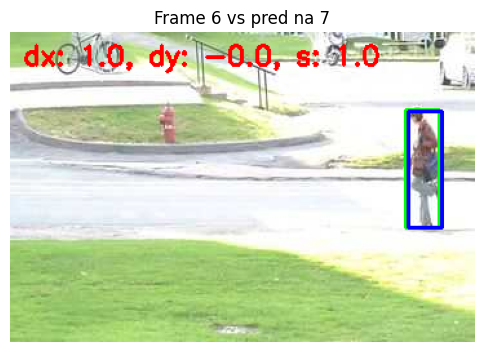

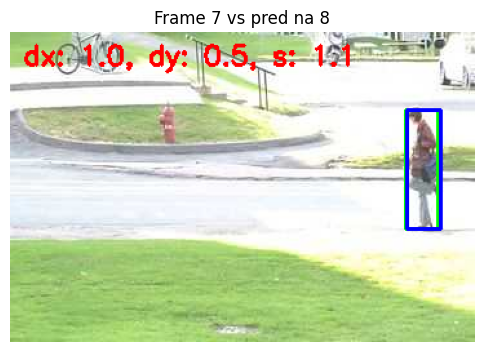

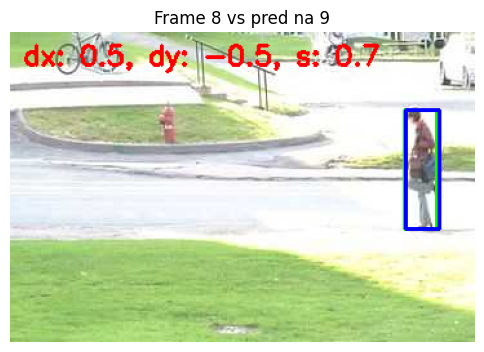

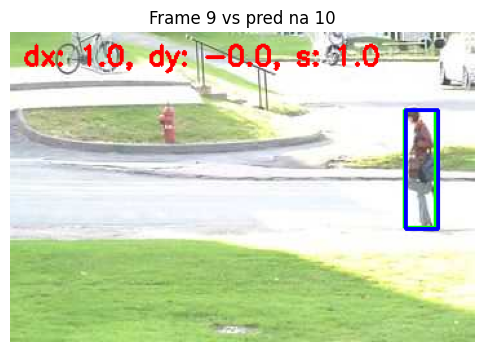

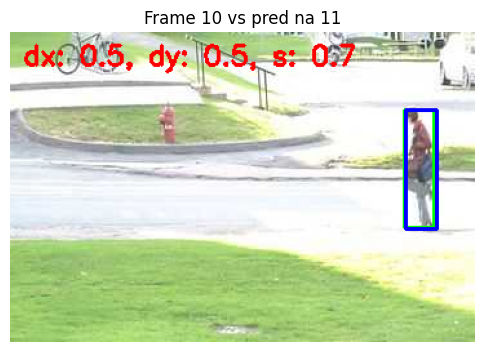

In [79]:
groundtruth_array = gt_array 

num_frames_to_check = 10
assert len(groundtruth_array) >= num_frames_to_check, "Za mało ramek GT"

for i in range(1, num_frames_to_check):
    tracker = init_tracking(groundtruth_array[i-1:i+1])

    predicted_box = [
        int(round(groundtruth_array[i][0] + tracker['dx'])),
        int(round(groundtruth_array[i][1] + tracker['dy'])),
        int(round(groundtruth_array[i][2] + tracker['dx'])),
        int(round(groundtruth_array[i][3] + tracker['dy']))
    ]

    img = colour_images_array[i + 1].copy()

    cv2.rectangle(img, (groundtruth_array[i+1][0], groundtruth_array[i+1][1]),
                       (groundtruth_array[i+1][2], groundtruth_array[i+1][3]), (0, 255, 0), 2)
    cv2.rectangle(img, (predicted_box[0], predicted_box[1]),
                       (predicted_box[2], predicted_box[3]), (255, 0, 0), 2)

    text = f"dx: {tracker['dx']:.1f}, dy: {tracker['dy']:.1f}, s: {tracker['s']:.1f}"
    cv2.putText(img, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1} vs pred na {i+2}")
    plt.axis("off")
    plt.show()


# Object tracking iteration

In [80]:
def improved_semi_supervised_object_tracking(gray_images_array, colour_images_array, groundtruth_array, min_iou_threshold=0.1, max_lost=5):
    def compute_iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interW = max(0, xB - xA)
        interH = max(0, yB - yA)
        interArea = interW * interH
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        unionArea = boxAArea + boxBArea - interArea
        return interArea / unionArea if unionArea > 0 else 0

    def predict_tracker_position(tracker):
        x1, y1, x2, y2 = tracker['prev_tracker']
        dx, dy = tracker['dx'], tracker['dy']
        return [
            int(round(x1 + dx)),
            int(round(y1 + dy)),
            int(round(x2 + dx)),
            int(round(y2 + dy))
        ]

    results = []
    tracker = init_tracking(groundtruth_array)
    lost_counter = 0
    poor_iou_counter = 0

    for idx in range(3, len(gray_images_array)):
        gray_img = gray_images_array[idx]
        colour_img = colour_images_array[idx]

        granules = quad_tree_granulation(gray_img)
        new_threshold, _ = compute_optimal_threshold(gray_img, granules, tracker['prev_threshold'])
        spatial_mask = (gray_img >= new_threshold).astype(np.uint8)
        f_t, f1, f2, f3 = gray_img, gray_images_array[idx - 1], gray_images_array[idx - 2], gray_images_array[idx - 3]
        temporal_mask = estimate_background_mask(f_t, f1, f2, f3)

        cx0, cy0 = center(tracker['prev_prev_tracker'])
        cx1, cy1 = center(tracker['prev_tracker'])
        dx, dy = -(cx1 - cx0), -(cy1 - cy0)
        s = np.sqrt((cx1 - cx0)**2 + (cy1 - cy0)**2)

        Txl, Tyl, Txu, Tyu = tracker['prev_tracker']
        exp_x = s * (1.25 if dx > 0 else 0.75)
        cont_x = s * (0.75 if dx > 0 else 1.25)
        exp_y = s * (1.25 if dy > 0 else 0.75)
        cont_y = s * (0.75 if dy > 0 else 1.25)
        Txl = int(round(Txl - cont_x))
        Txu = int(round(Txu + exp_x))
        Tyl = int(round(Tyl - cont_y))
        Tyu = int(round(Tyu + exp_y))

        h, w = gray_img.shape
        Txl, Tyl, Txu, Tyu = max(0, Txl), max(0, Tyl), min(w - 1, Txu), min(h - 1, Tyu)

        combined_mask = cv2.bitwise_and(spatial_mask, temporal_mask)
        roi_mask = combined_mask[Tyl:Tyu, Txl:Txu]
        roi_rgb = colour_img[Tyl:Tyu, Txl:Txu]
        R, G, B = roi_rgb[:, :, 0], roi_rgb[:, :, 1], roi_rgb[:, :, 2]
        mask_fg = roi_mask > 0

        if np.sum(mask_fg) == 0:
            lost_counter += 1
            predicted = predict_tracker_position(tracker)
        else:
            lost_counter = 0
            mean_R = np.mean(R[mask_fg])
            mean_G = np.mean(G[mask_fg])
            mean_B = np.mean(B[mask_fg])
            max_dev_R = np.max(np.abs(R[mask_fg] - mean_R))
            max_dev_G = np.max(np.abs(G[mask_fg] - mean_G))
            max_dev_B = np.max(np.abs(B[mask_fg] - mean_B))

            mask_rgb = (
                (np.abs(R - mean_R) < max_dev_R) &
                (np.abs(G - mean_G) < max_dev_G) &
                (np.abs(B - mean_B) < max_dev_B) &
                (roi_mask > 0)
            ).astype(np.uint8)

            coords = cv2.findNonZero(mask_rgb)
            if coords is not None:
                x, y, w_, h_ = cv2.boundingRect(coords)
                predicted = [Txl + x, Tyl + y, Txl + x + w_, Tyl + y + h_]
            else:
                lost_counter += 1
                predicted = predict_tracker_position(tracker)

        results.append(predicted)

        if idx < len(groundtruth_array):
            iou = compute_iou(predicted, groundtruth_array[idx])
            poor_iou_counter = poor_iou_counter + 1 if iou < min_iou_threshold else 0

        if lost_counter >= max_lost or poor_iou_counter >= max_lost:
            print(f"🛑 Tracker deaktywowany (zgubienie lub niskie IoU przez {max_lost} klatek).")
            break

        tracker.update({
            'prev_prev_tracker': tracker['prev_tracker'],
            'prev_tracker': predicted,
            'prev_threshold': new_threshold,
            'dx': dx,
            'dy': dy,
            's': s
        })

    return results


In [81]:
def mask_to_bbox(mask):
    coords = cv2.findNonZero(mask.astype(np.uint8))
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return [x, y, x + w, y + h]
    else:
        return [0, 0, 0, 0]  


groundtruth_array = []

for fname in frame_files:
    gt_path = os.path.join(gt_dir, fname.replace('in', 'gt').replace('.jpg', '.png'))
    gt_mask = load_ground_truth(gt_path)  
    bbox = mask_to_bbox(gt_mask)
    groundtruth_array.append(bbox)


def bbox_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea if unionArea > 0 else 0


def center_distance(boxA, boxB):
    cxA = (boxA[0] + boxA[2]) / 2
    cyA = (boxA[1] + boxA[3]) / 2
    cxB = (boxB[0] + boxB[2]) / 2
    cyB = (boxB[1] + boxB[3]) / 2
    return np.sqrt((cxA - cxB) ** 2 + (cyA - cyB) ** 2)


def test_tracker(gray_images_array, colour_images_array, groundtruth_array, granules):
    predicted_boxes = improved_semi_supervised_object_tracking(
    gray_images_array,
    colour_images_array,
    groundtruth_array,
    min_iou_threshold=0.1,  
    max_lost=10              
    )

    ious = []
    distances = []
    for i, pred in enumerate(predicted_boxes):
        gt = groundtruth_array[i + 2]
    
        if gt == [0, 0, 0, 0]:
            continue  
        
        iou = bbox_iou(pred, gt)
        dist = center_distance(pred, gt)
        ious.append(iou)
        distances.append(dist)


    print("📈 Tracker performance:")
    print(f"Mean IoU:      {np.mean(ious):.4f}")
    print(f"Mean Distance: {np.mean(distances):.2f} px")

    return ious, distances, predicted_boxes

granules = quad_tree_granulation(gray_images_array[0])
ious, distances, preds = test_tracker(gray_images_array, colour_images_array, groundtruth_array, granules)


🛑 Tracker deaktywowany (zgubienie lub niskie IoU przez 10 klatek).
📈 Tracker performance:
Mean IoU:      0.1869
Mean Distance: 43.67 px


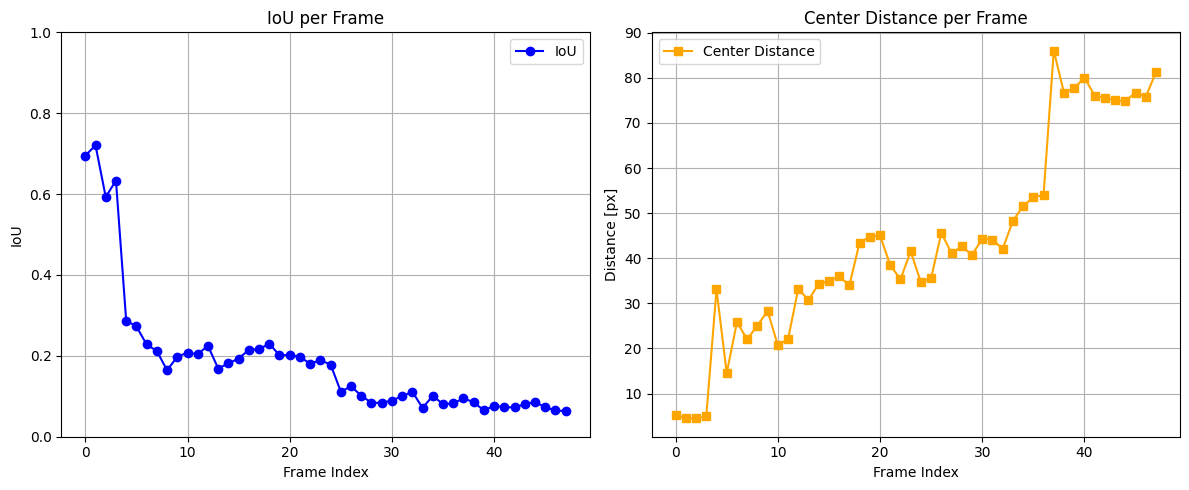

In [82]:
def plot_tracker_metrics(ious, distances, save_path=None):
    frames = np.arange(len(ious))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(frames, ious, marker='o', color='blue', label='IoU')
    plt.title("IoU per Frame")
    plt.xlabel("Frame Index")
    plt.ylabel("IoU")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(frames, distances, marker='s', color='orange', label='Center Distance')
    plt.title("Center Distance per Frame")
    plt.xlabel("Frame Index")
    plt.ylabel("Distance [px]")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"✅ Wykres zapisany do: {save_path}")

    plt.show()

plot_tracker_metrics(ious, distances)


In [83]:
def save_tracking_video(output_path, colour_images_array, predicted_boxes, fps=10):
    h, w, _ = colour_images_array[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    for i in range(len(predicted_boxes)):
        frame = colour_images_array[i + 3].copy()  

        print(f'frame nr{ i + 3} - {predicted_boxes[i]}')

        x1, y1, x2, y2 = predicted_boxes[i]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"Frame {i + 3}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 255, 255), 2)

        out.write(frame)

    out.release()
    print(f"🎥 Zapisano plik wideo: {output_path}")


save_tracking_video("tracker_output.mp4", colour_images_array, preds)


frame nr3 - [309, 64, 345, 140]
frame nr4 - [303, 60, 340, 144]
frame nr5 - [299, 56, 344, 148]
frame nr6 - [304, 58, 344, 148]
frame nr7 - [301, 57, 333, 89]
frame nr8 - [278, 56, 359, 128]
frame nr9 - [254, 48, 344, 130]
frame nr10 - [239, 57, 352, 153]
frame nr11 - [232, 48, 352, 160]
frame nr12 - [240, 45, 336, 160]
frame nr13 - [248, 47, 341, 160]
frame nr14 - [240, 56, 344, 160]
frame nr15 - [236, 50, 323, 156]
frame nr16 - [226, 40, 340, 157]
frame nr17 - [219, 40, 336, 160]
frame nr18 - [215, 33, 336, 160]
frame nr19 - [212, 30, 336, 155]
frame nr20 - [209, 39, 341, 146]
frame nr21 - [208, 38, 323, 145]
frame nr22 - [201, 32, 328, 147]
frame nr23 - [199, 32, 328, 150]
frame nr24 - [208, 32, 330, 151]
frame nr25 - [208, 32, 334, 153]
frame nr26 - [205, 32, 319, 153]
frame nr27 - [198, 48, 330, 160]
frame nr28 - [183, 33, 339, 169]
frame nr29 - [180, 32, 320, 168]
frame nr30 - [172, 37, 334, 182]
frame nr31 - [160, 31, 341, 189]
frame nr32 - [158, 32, 344, 191]
frame nr33 - [156,